In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now().date()} / Aki Taanila')

Päivitetty 2024-05-10 / Aki Taanila


# Luokittelumallien kokeilua

Olen lainannut ideoita lähteestä: https://www.kaggle.com/code/nayansakhiya/heart-fail-analysis-and-quick-prediction

Tässä opetetaan malli, joka ennakoi kuolemaan johtavaa sydämen pettämistä.

Kokeilen seuraavia malleja:

* **Logistinen regressio** (paljon käytetty perinteinen luokittelumalli)
* **Päätöspuu** (helposti havainnollistettava malli)
* **Satunnaismetsä** (tehokas menetelmä, joka sopii erityisesti ylisovittamisen välttämiseen)
* **Gradienttitehostus** (tehokas menetelmä, joka antaa usein muita menetelmiä tarkempia ennusteita)


Käytettävistä malleista satunnaismetsä ja gradienttitehostus ovat niin kutsuttuja **ensemble**-malleja (yhdistelmämalleja), joissa malli on usean mallin yhdistelmä. Satunnaismetsä ja gradienttitehostus perustuvat päätöspuihin.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train_test_split osaa jakaa datan opetusdataan ja testidataan
from sklearn.model_selection import train_test_split

# Käytettävät mallit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Sekaannusmatriisin näyttämiseen
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Datan tarkastelua

In [3]:
df=pd.read_excel('https://taanila.fi/heart.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   nro                       299 non-null    int64  
 1   age                       299 non-null    float64
 2   anaemia                   299 non-null    int64  
 3   creatinine_phosphokinase  299 non-null    int64  
 4   diabetes                  299 non-null    int64  
 5   ejection_fraction         299 non-null    int64  
 6   high_blood_pressure       299 non-null    int64  
 7   platelets                 299 non-null    float64
 8   serum_creatinine          299 non-null    float64
 9   serum_sodium              299 non-null    int64  
 10  sex                       299 non-null    int64  
 11  smoking                   299 non-null    int64  
 12  time                      299 non-null    int64  
 13  DEATH_EVENT               299 non-null    int64  
dtypes: float64

Kohdemuuttuja on **DEATH_EVENT**.

In [4]:
df

,nro,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,1,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,2,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,3,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,4,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,5,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,295,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,296,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,297,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,298,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [5]:
# Kohdemuuttujan arvojen jakauma
df['DEATH_EVENT'].value_counts()

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

Potilaista 203 selvisi hengissä ja 96 kuoli.

<Axes: >

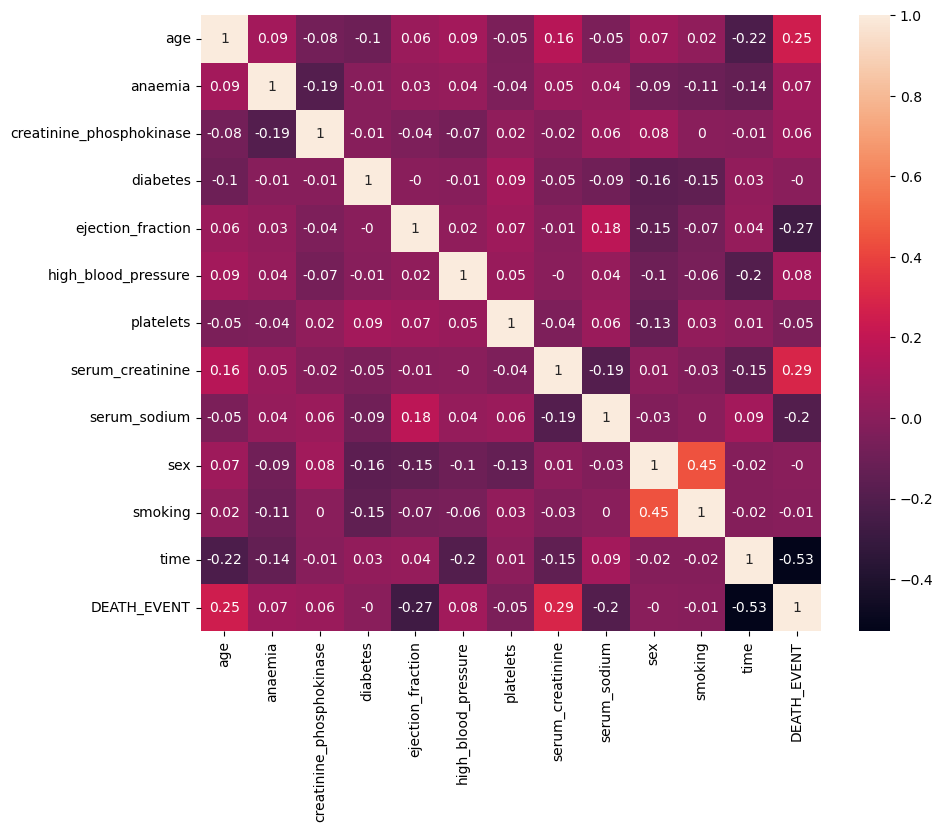

In [6]:
# Korrelaatiot
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop('nro', axis=1).corr().round(2), annot=True)

Valitsen jatkoon selittävät muuttuja, joilla on suurimmat korrelaatiot kohdemuuttujan kanssa. Rajoitun kolmeen selittävään muuttujaan käyttämäni lähteen https://www.kaggle.com/code/nayansakhiya/heart-fail-analysis-and-quick-prediction perusteella.

<Axes: xlabel='DEATH_EVENT', ylabel='time'>

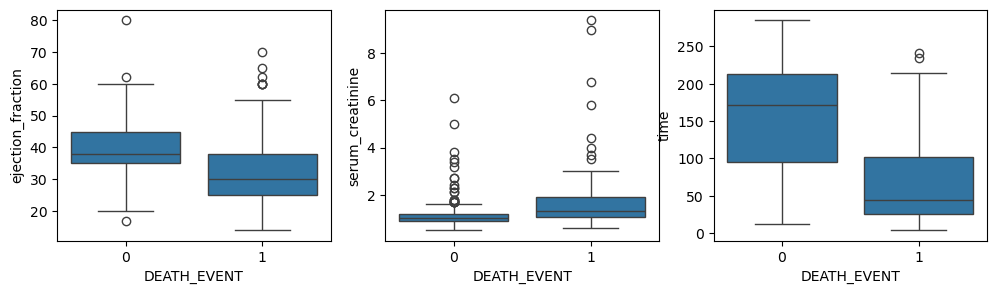

In [7]:
# Katson miten hyvin korrelaatioltaan suurimmat muuttujat erottelevat 
# selvinneitä (0) ja menehtyneitä (1)

fig, axes = plt.subplots(1, 3, figsize=(12,3))

sns.boxplot(x='DEATH_EVENT', y='ejection_fraction', data=df, ax=axes[0])
sns.boxplot(x='DEATH_EVENT', y='serum_creatinine', data=df, ax=axes[1])
sns.boxplot(x='DEATH_EVENT', y='time', data=df, ax=axes[2])

Jatkoon otetut kolme muuttujaa eivät kovin hyvin näytä erottelevan. Kuitenkin osoittautuu, että yhdessä nämä kolme muuttujaa tuottavan hyvän mallin.

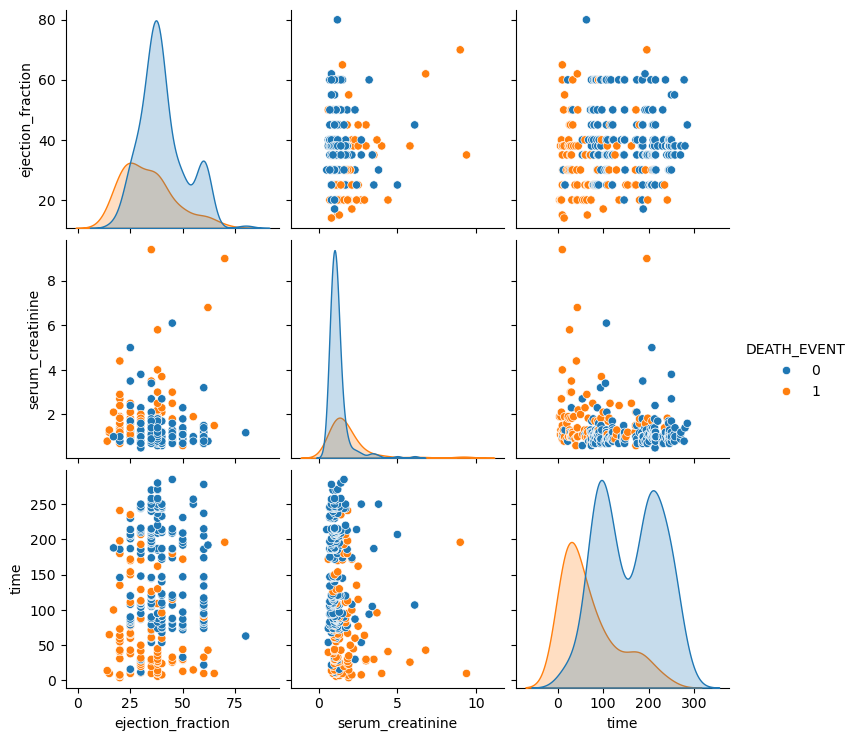

In [8]:
# Katson erottelevuutta myös hajontakaavioina 
sns.pairplot(df[['ejection_fraction', 'serum_creatinine', 'time', 'DEATH_EVENT']], hue = 'DEATH_EVENT')

## Mallien sovitus

In [9]:
# Selittävät muuttujat
X = df[['ejection_fraction', 'serum_creatinine', 'time']]

# Kohdemuuttuja
y = df['DEATH_EVENT']

# Datan jako opetus- ja testidataan
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

Käytän **random_state**-parametrilla kiinteää arvoa, jotta saan eri suorituskerroilla saman jaon opetus- ja testidataan. Jos vaihdan arvoa niin saan erilaisien jaon ja sen seurauksena hieman erilaiset mallit.

In [10]:
lrc = LogisticRegression(random_state=2)
lrc.fit(X_train, y_train)

dtc = DecisionTreeClassifier(max_depth=4, random_state=2)
dtc.fit(X_train, y_train)

rfc = RandomForestClassifier(max_depth=3, random_state=2)
rfc.fit(X_train, y_train)

gbc = GradientBoostingClassifier(max_depth=3, random_state=2)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=2)

**Satunnaimetsä** ja **gradienttitehostus** ovat yhdistelmämalleja useista päätöspuista. Päätöspuiden haarautumisten määrää säädellään **max_depth**-parametrilla. Voit kokeilla myös muita arvoja.

## Mallien arviointia

In [11]:
print('Ennusteiden tarkkuus opetusdatassa:')
print(f'Logistinen regressio {lrc.score(X_train, y_train):.3f}')
print(f'Päätöspuu {dtc.score(X_train, y_train):.3f}')
print(f'Satunnaismetsä {rfc.score(X_train, y_train):.3f}')
print(f'Gradienttitehostus {gbc.score(X_train, y_train):.3f}')

Ennusteiden tarkkuus opetusdatassa:
Logistinen regressio 0.817
Päätöspuu 0.893
Satunnaismetsä 0.884
Gradienttitehostus 0.960


In [12]:
print('Ennusteiden tarkkuus testidatassa:')
print(f'Logistinen regressio {lrc.score(X_test, y_test):.3f}')
print(f'Päätöspuu {dtc.score(X_test, y_test):.3f}')
print(f'Satunnaismetsä {rfc.score(X_test, y_test):.3f}')
print(f'Gradienttitehostus {gbc.score(X_test, y_test):.3f}')

Ennusteiden tarkkuus testidatassa:
Logistinen regressio 0.880
Päätöspuu 0.907
Satunnaismetsä 0.920
Gradienttitehostus 0.920


In [13]:
# Mallien laskemat ennusteet testidatalle (tarvitaan sekaannusmatriisien luomiseen)
y_test_dtc = dtc.predict(X_test)
y_test_lrc = lrc.predict(X_test)
y_test_rfc = rfc.predict(X_test)
y_test_gbc = gbc.predict(X_test)

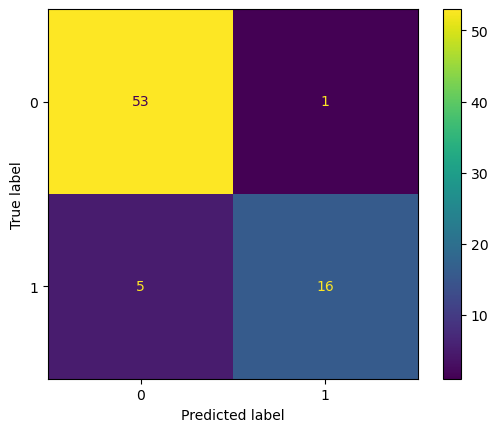

In [14]:
# Satunnaismetsän sekaannus-matriisi testidatalle
cm = confusion_matrix(y_test, y_test_rfc)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

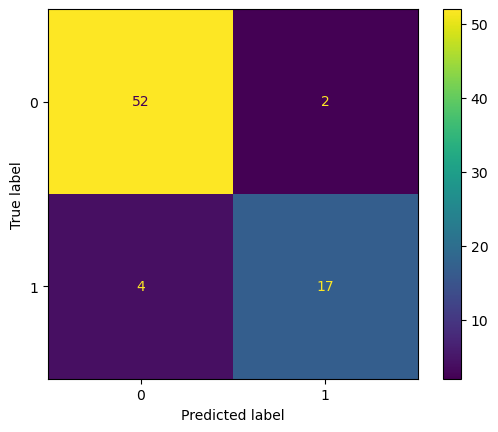

In [15]:
# Gradienttitehostuksen sekaannus-matriisi testidatalle
cm = confusion_matrix(y_test, y_test_gbc)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

#### Selitystä gradienttitehostuksen sekaannusmatriisille

* Selviytyneistä 52 ennustettiin oikein selviytyjiksi ja 2 ennustettiin virheellisesti menehtyjäksi.

* Menehtyneistä 17 ennustettiin oikein menehtyjiksi ja 4 ennustettiin virheellisesti selviytyjiksi.

## Mallin käyttö ennustamiseen

Käytän mallina gradienttitehostusta.

In [16]:
# Data kahdelle uudelle henkilölle
Xnew = pd.DataFrame([[20, 5, 10], [50, 2, 80]], 
                    columns = ['ejection_fraction', 'serum_creatinine', 'time'])
Xnew

,ejection_fraction,serum_creatinine,time
0,20,5,10
1,50,2,80


In [17]:
ennuste = gbc.predict(Xnew)
todnak = gbc.predict_proba(Xnew).round(2)
Xnew['ennuste'] = ennuste
Xnew[['DEATH_EVENT 0', 'DEATH_EVENT 1']] = todnak
Xnew

,ejection_fraction,serum_creatinine,time,ennuste,DEATH_EVENT 0,DEATH_EVENT 1
0,20,5,10,1,0.02,0.98
1,50,2,80,0,0.65,0.35


Gradienttitehostus ennustaa ensimmäisen potilaan menehtyvän 98 % todennäköisyydellä ja toisen selviytyvän 65 % todennäköisyydellä.

## Lisätietoa

Logistisen regression taustaa: https://tilastoapu.wordpress.com/2014/04/25/logistinen-regressio/

Yhdistelmämallien (ensemble) taustaa: https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205 

Data-analytiikka Pythonilla: https://tilastoapu.wordpress.com/python/